# Dynes fit in SIS Tunneljunction

In [1]:
# initialize stuff
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import importlib
import logging

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/Users/oliver/Documents/p5control-bluefors-evaluation")
sys.path.append("/home/oliver/Documents/p5control-bluefors-evaluation")

from utilities.baseclass import BaseClass
from utilities.baseevaluation import BaseEvaluation
from utilities.baseplot import BasePlot
from utilities.ivevaluation import IVEvaluation

importlib.reload(sys.modules["utilities.baseclass"])
importlib.reload(sys.modules["utilities.baseevaluation"])
importlib.reload(sys.modules["utilities.baseplot"])
importlib.reload(sys.modules["utilities.ivevaluation"])

import utilities.basefunctions
importlib.reload(sys.modules["utilities.basefunctions"])

from utilities.corporate_design_colors_v4 import cmap
importlib.reload(sys.modules["utilities.corporate_design_colors_v4"])

importlib.reload(logging)
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format="%(message)s")
# pip install numpy matplotlib scipy tqdm torch hdf5view h5py PySide6


import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import jv
from scipy.interpolate import interp1d
from numpy.typing import NDArray

In [2]:
# Constants
h = 6.62607015e-34  # V * A * s²
e = 1.602176634e-19 #     A * s
G_0 = 2*e**2/h      # A / V
R_0 = h/(2*e**2)    # V / A

k_B = 8.617333262e-5  # eV / K

V_gap = 191.72e-6   # V
Delta = V_gap*e     # V * A * s
nu = 15e9           # 1 / s
pincode = np.array([0.05]) # 0.05 G0

# Exp Data 0.05 $G_0$

(base) ... BaseClass initialized.
(base eva) ... BaseEvaluation initialized.
(iv eva) ... IVEvaluation initialized.
(base) ... BaseClass initialized.
(base plot) ... BasePlot initialized.
(iv plot) ... IVPlot initialized.
(base) Amplitude Study (0.05G0, 15GHz, Stripline)
(base) loadData()
(iv plot) smoothing = True
(iv plot) window_length = 10
(base plot) saveFigure()
(base plot) saveFigure()


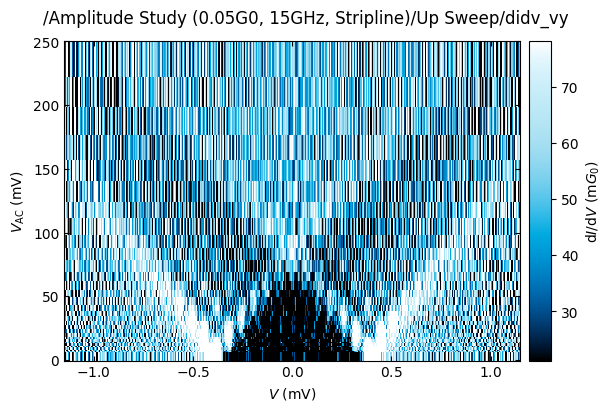

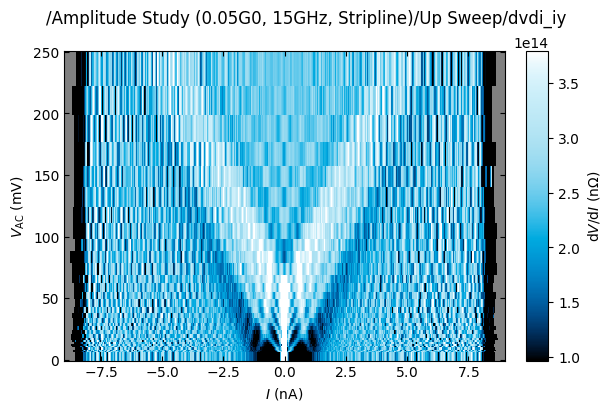

In [3]:
# get exp data
%matplotlib inline
from utilities.ivplot import IVPlot
importlib.reload(sys.modules["utilities.ivplot"])


eva = IVPlot()
eva.file_directory = '/Volumes/speedyboy/measurement data 2/'
eva.file_folder = '2023-10-27_HIV_tunnel_contact/'
eva.file_name = '2023-10-27_HIV_tunnel_contact_1.hdf5'
eva.setAmplifications(1000, 10000)
eva.setV(V_gap*5.99, voltage_bins=1198)
eva.setI(9e-9, current_bins=1000)
eva.setA(0, 0.25, 250)
eva.downsample_frequency = 70

# Amplitude Study (0.05G0, 15GHz, Stripline)
eva.title = "Amplitude Study (0.05G0, 15GHz, Stripline)"
eva.sub_folder = ""
eva.data_folder = "exp_data"

# # Comment this Block, if measurement data are not available
# eva.setMeasurement("frequency_at_15GHz")
# eva.setKeys(index_0=3, index_1=-3, norm=1)
# eva.showKeys()
# eva.addKey('nu=-31.0dBm', -1000)
# eva.up_sweep, = eva.getMaps([1])
# eva.up_sweep, = eva.getMapsAmplitude([eva.up_sweep])
# eva.y_axis = eva.amplitude_axis
# eva.saveData()

eva.loadData()
eva.figure_folder = "exp_data"
eva.to_plot = eva.up_sweep
eva.title_of_plot = "Up Sweep"
eva.y_characters = [r"$V_\mathrm{AC}$", "V"]
eva.smoothing = True
eva.window_length = 10
eva.plot_T = False
eva.plot_all()


In [4]:
# rescale & Smoothing
I_exp = eva.up_sweep['current']

dIdV_exp = eva.up_sweep["differential_conductance"]
V_bias_exp = eva.mapped["voltage_axis"]
V_AC = eva.mapped["amplitude_axis"]

I_0_exp = I_exp[0,:]
dIdV_0_exp = dIdV_exp[0, :]
V_0_exp = np.linspace(-5.99, 5.99, 1199, dtype='float64')


from scipy.signal import savgol_filter
I_0_exp = savgol_filter(
    I_0_exp,
    window_length=35,
    polyorder=2,
    )
# dIdV_0_exp = savgol_filter(
#     dIdV_0_exp,
#     window_length=10,
#     polyorder=2,
#     )

V_exp = V_bias_exp # V
I_exp = I_0_exp # A
dIdV_exp = dIdV_0_exp # G_0

In [5]:
# check with theoretical data
with open("CarlosIV/CarlosIV.pickle", "rb") as file:
    carlos = pickle.load(file)

V_theo = carlos["V"]*V_gap # V
I_theo = carlos["I"][6,:]*(2*e*Delta/h) # A
dIdV_theo = carlos["dIdV"][6,:] # G_0

%matplotlib qt
# plt.plot(V_exp, dIdV_exp, 'b.', ms=2)
# plt.plot(-V_exp, dIdV_exp, 'r.', ms=2)
# plt.plot(V_theo, dIdV_theo, '-', color='grey')
plt.plot(V_exp, I_exp, 'b.', ms=2)
plt.plot(-V_exp, -I_exp, 'r.', ms=2)
plt.plot(V_theo, I_theo, '-', color='grey')


# Dynes Model

Calculate Current from Density of States $N(E)$ and Fermi-Dirac Distribution $F(E)$, respectively depending on the energy $E$.
$$
I(V) = \frac{G_N}{G_0} \int^{\infty}_{-\infty} N(E) \cdot N(E - eV) \cdot \left[f(E) - f(E - eV)\right] \, \mathrm{d}E\,,
$$


For a Superconductor-Insulator-Superconductor (SIS) Junction we asume a Density of States
$$
N_\mathrm{S}(E) = \sqrt{\frac{E^2}{E^2-\Delta^2}}\,,
$$
with $\Delta$ as energy gap.

Considering the phenomenological Dynes parameter, the density of states becomes
$$
N_\mathrm{S}(E) = \Re\left\{\sqrt{\frac{(E-i\Gamma)^2}{(E-i\Gamma)^2-\Delta^2}}\right\}\,,
$$
with $\Gamma$ as Dynes parameter.

The Fermi-Dirac Distribution is given by
$$
f(E, T) = \frac{1}{1+\exp({E/k_\mathrm{B}T})}\,,
$$
with temperature $T$ and boltzman constant $k_\mathrm{B}$.

Asuming $6\Delta\approx\infty$, we can use the following fomula
$$

I(V) \approx \frac{G_\mathrm{N}}{G_0} \int_{-6\Delta}^{6\Delta} N_\mathrm{S}(E, \Delta, \Gamma) \cdot N_\mathrm{S}(E + eV, \Delta, \Gamma) \cdot \left[f(E, T) - f(E + eV, T)\right] \mathrm{d}E\,,
$$
with $\Delta$, $\Gamma$, $T$ and $G_\mathrm{N}$ as fitting parameter.

In order to solve the Formula numerically, we are using the Trapezoid algorithm
$$
\int_a^b f(x) \mathrm{d}x = \sum_{k=1}^N \frac{f(x_{k-1}) - f(x_k)}{2}  (x_k- x_{k-1})\,.
$$

In [6]:
# Model
import numpy as np

def f(E, T):
    k_B = 8.617333262e-5  # eV / K
    exponent = np.clip(E / (k_B * T), -100, 100)  # clip to avoid overflow
    return 1 / (np.exp(exponent) + 1)


# def f(E,T):
#     k_B = 8.617333262e-5  # eV / K
#     return 1 / (1 + np.exp(E / (k_B * T)))

def N(E, Delta, Gamma):  # Dynes density of states
    N_E = np.real((E + 1j * Gamma) / np.sqrt((E + 1j * Gamma)**2 - Delta**2))
    N_E[N_E<-10]=np.nan
    N_E[N_E>10]=np.nan
    return N_E

# def f(E, T=0):
#     """Fermi-Dirac distribution at T = 0."""
#     return np.where(E < 0, 1.0, 0.0)

# def N(E, Delta, Gamma=0):  # BCS density of states
#     N_E = E / np.sqrt(E**2 - Delta**2)
#     N_E[N_E<-10]=np.nan
#     N_E[N_E>10]=np.nan
#     return np.real(N_E)

def tunneling_current(V, Delta, Gamma, T, G_N):
    """
    Computes the tunneling current for a symmetric superconductor–superconductor (S–S) junction
    using the Dynes density of states, over an array of voltages V_array.
    
    Parameters
    ----------
    V : array_like
        Array of bias voltages (in eV).
    Delta : float
        Superconducting gap (in eV).
    Gamma : float
        Broadening parameter (in eV).
    T : float
        Temperature (in Kelvin).
    G_N : float
        Normal Conductance of the junction (in G_0).
    
    Returns
    -------
    I : ndarray
        Tunneling current for each bias voltage.
    """
    
    c: int = 1
    d: int = 4

    h = 6.62607015e-34  # V * A * s²
    e = 1.602176634e-19 #     A * s
    G_0 = 2*e**2/h      # A / V

    E = np.linspace(
        -5.99 * Delta * c, 
         5.99 * Delta * c, 
         1 + 1198 * c * d
         ) # eV

    E_mesh, V_mesh = np.meshgrid(E, V)
    N1 = N(E_mesh, Delta, Gamma)
    N2 = N(E_mesh - V_mesh, Delta, Gamma)
    f1 = f(E_mesh, T)
    f2 = f(E_mesh - V_mesh, T)

    integrand = N1 * N2 * (f1 - f2)
    integrand[np.isnan(integrand)]=0
    if not np.all(np.isfinite(integrand)):
        raise ValueError("NaN or inf in integrand")
    I = np.trapezoid(integrand, E, axis=1) * G_N * G_0 # A
    # dIdV = np.gradient(I, V) / G_0 # G_0
    return I#, dIdV



# Genetic Algorithm Optimizer

In [11]:
# Settings
num_generations = 30
sol_per_pop = 10

gene_space = [
    {"low": 188e-6, "high": 194e-6},   # Delta
    {"low": 1e-6,   "high": 20e-6},    # Gamma
    {"low": 0.30,   "high": 0.60},     # T
    {"low": 0.049,  "high": 0.052},    # G_N
]

def symmetric_weight(x):
    sigma = 2
    return np.exp(-0.5 * ((x - 2) / sigma)**2) + np.exp(-0.5 * ((x + 2) / sigma)**2) + np.exp(-0.5 * ((x - 1) / sigma)**2) + np.exp(-0.5 * ((x + 1) / sigma)**2)

%matplotlib qt
plt.close(0)
plt.figure(0)
plt.plot(V_exp/V_gap, symmetric_weight(V_exp/Delta))
plt.xlabel(r"$eV_\mathrm{bias}$ ($\Delta$)")
plt.ylabel(r"$w$ (arb. units)")

Text(0, 0.5, '$w$ (arb. units)')

In [ ]:
# run genetic algorith
import pygad
import numpy as np
from tqdm import tqdm

pbar = tqdm(total=num_generations, desc="GA Progress")

# Callback-Funktion, die nach jeder Generation aufgerufen wird
def on_generation(ga_instance):
    pbar.update(1)

def fitness_func(ga, solution, solution_idx):
    Delta, Gamma, T, G_N = solution
    I_model = tunneling_current(V_exp, Delta, Gamma, T, G_N)

    # Mean squared error between model and data
    weight=symmetric_weight(V_exp/Delta)
    error = np.mean((I_model - I_exp)**2*weight)

    # Return negative error (GA maximizes the fitness)
    return -error

ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=int(sol_per_pop/3),
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop,
    num_genes=4,
    keep_parents=2,
    gene_space=gene_space,
    mutation_by_replacement=True,
    parent_selection_type="tournament",
    mutation_type="random",
    crossover_type="single_point",
    mutation_num_genes=1,
    on_generation=on_generation,
    )

ga_instance.run()
pbar.close()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Best solution parameters:", solution)

Delta, Gamma, T, G_N = solution
print("-------------------------------------------------------")
print(f"Δ={Delta*1e6:.3f} µeV, Γ={Gamma*1e6:05.1f} µeV, T={T*1e3:05.1f} mK, G_N={G_N:.3f}, u={-solution_fitness*1e21:08.4f}")
solution

GA Progress:   0%|          | 0/30 [00:00<?, ?it/s]

GA Progress: 100%|██████████| 30/30 [00:42<00:00,  1.42s/it]


Best solution parameters: [1.91744114e-04 5.57409998e-06 4.14830623e-01 4.90000000e-02]
-------------------------------------------------------
Δ=191.744 µeV, Γ=005.6 µeV, T=414.8 mK, G_N=0.049, error=000.2049


array([1.91744114e-04, 5.57409998e-06, 4.14830623e-01, 4.90000000e-02])

In [12]:
solution = np.array([1.92229961e-04, 6.71497087e-06, 4.55987003e-01, 5.10390943e-02])

In [105]:
# show solution
I_fit = tunneling_current(V_exp, *solution)
dIdV_fit = np.gradient(I_fit, V_exp)/G_0

%matplotlib qt

plt.close(1)
plt.figure(1)
plt.plot(V_theo/V_gap, I_theo, '-', color='grey', label='theo')
plt.plot(V_exp/V_gap, I_exp, 'r.', ms=5, label='exp')
plt.plot(V_exp/V_gap, I_fit, 'k-', label='fit')
plt.xlabel(r"$eV_\mathrm{bias}$ ($\Delta$)")
plt.ylabel("$I$ (A)")
plt.legend()
plt.grid()

plt.close(2)
plt.figure(2)
plt.plot(V_theo/V_gap, dIdV_theo, '-', color='grey', label='theo')
plt.plot(V_exp/V_gap, dIdV_exp, 'r.', ms=5, label='exp')
plt.plot(V_exp/V_gap, dIdV_fit, 'k-', label='fit')
plt.xlabel(r"$eV_\mathrm{bias}$ ($\Delta$)")
plt.ylabel(r"d$I/$d$V$ ($G_0$)")
plt.legend()
plt.grid()

# Print results
print(f"Fitted parameters:")
print(f"Delta = {solution[0]*1e6:.1f} µeV")
print(f"Gamma = {solution[1]*1e6:.2f} µeV")
print(f"T     = {solution[2]:.3f} K")
print(f"G_N   = {solution[3]:.3f} G0")

Fitted parameters:
Delta = 192.2 µeV
Gamma = 6.71 µeV
T     = 0.456 K
G_N   = 0.051 G0


In [106]:
# fit by eye
Delta=191.5e-6
Gamma=6e-6
T=0.08
G_N=0.051

I_fit = tunneling_current(V_exp, 
                          Delta=Delta,
                          Gamma=Gamma,
                          T=T,
                          G_N=G_N)

weight = symmetric_weight(V_exp/Delta)
error = np.mean((I_fit - I_exp)**2)
dIdV_fit = np.gradient(I_fit, V_exp)/G_0

print(f"error = {error*1e21:08.4f}")


error = 001.1207


In [107]:
# show 

%matplotlib qt

plt.close(1)
plt.figure(1)
# plt.plot(V_theo, I_theo, '-', color='grey', label='theo')
plt.plot(V_exp/V_gap, I_exp, 'r.', ms=5, label='exp')
plt.plot(V_exp/V_gap, I_fit, 'k-', label='fit')
plt.xlabel(r"$eV_\mathrm{bias}$ ($\Delta$)")
plt.ylabel("$I$ (A)")
plt.legend()
plt.grid()

# plt.close(2)
# plt.figure(2)
# # plt.plot(V_theo, dIdV_theo, '-', color='grey', label='theo')
# plt.plot(V_exp/V_gap, dIdV_exp, 'r.', ms=5, label='exp')
# plt.plot(V_exp/V_gap, dIdV_fit, 'k-', label='fit')
# plt.xlabel(r"$eV_\mathrm{bias}$ ($\Delta$)")
# plt.ylabel(r"d$I/$d$V$ ($G_0$)")
# plt.legend()
# plt.grid()

# Print results
print(f"Fitted parameters:")
print(f"Delta = {Delta*1e6:.1f} µeV")
print(f"Gamma = {Gamma*1e6:.2f} µeV")
print(f"T     = {T*1e3:.3f} mK")
print(f"G_N   = {G_N:.3f} G0")
print(f"error = {error*1e21:08.4f}")

Fitted parameters:
Delta = 191.5 µeV
Gamma = 6.00 µeV
T     = 80.000 mK
G_N   = 0.051 G0
error = 001.1207


In [108]:
V = V_exp/V_gap#-.005

plt.close('all')
fig, ((ax_i, ax_didv), (ax_color, _)) = plt.subplots(2,2, num=1)

ax_i.plot(V, I_exp, '.', ms=5, color='grey', label='exp')
# ax_i.plot(-V, -I_exp, '.', ms=5, color='grey')

ax_didv.plot(V, np.gradient(I_exp, V_exp)/G_0, '.', ms=5, color='grey', label='exp')
# ax_didv.plot(-V, np.gradient(I_exp, V_exp)/G_0, '.', ms=5, color='grey')

gammas = np.array([0, 7e-6, 13e-6])
temperatures = np.array([0, .3, .6])

GAMMA, TEMP = np.meshgrid(gammas, temperatures)

cmap(color="seeblau")
cmap(color='seegrün')

for g in gammas:
    for t in temperatures:
        R = t/max(temperatures)
        B = g/max(gammas)
        color = [R, 0, B]
        i = tunneling_current(V_exp, V_gap, g, t, 0.05)
        didv = np.gradient(i, V_exp)/G_0

        ax_i.plot(V, i, color=color)
        ax_didv.plot(V, didv)

/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_72644/1771840290.py:6: RuntimeWarning: divide by zero encountered in divide
  exponent = np.clip(E / (k_B * T), -100, 100)  # clip to avoid overflow
/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_72644/1771840290.py:6: RuntimeWarning: invalid value encountered in divide
  exponent = np.clip(E / (k_B * T), -100, 100)  # clip to avoid overflow


In [ ]:
from matplotlib.gridspec import GridSpec
plt.close(1)
fig = plt.figure(1)
# fig.suptitle("Controlling spacing around and between subplots")

gs1 = GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[2, 1])
ax_i = fig.add_subplot(gs1[:-1, :])
ax_didv = fig.add_subplot(gs1[-1, :-1])
ax_color = fig.add_subplot(gs1[-1, -1])

ax_i.set_xlabel(r"$eV_\mathrm{bias}$ ($\Delta$)")
ax_i.set_ylabel("$I$ (nA)")
ax_didv.set_xlabel(r"$eV_\mathrm{bias}$ ($\Delta$)")
ax_didv.set_ylabel(r"d$I/$d$V$ ($G_0$)")
ax_i.xaxis.set_label_position('top') 
ax_i.xaxis.tick_top()

ax_color.set_xlabel("Gamma (µeV)")
ax_color.set_ylabel("Temperature (K)")
ax_color.yaxis.set_label_position('right') 
ax_color.yaxis.tick_right()

gammas = np.linspace(0, 12e-6,4)
temperatures = np.linspace(0, 1.2, 4)

cmap_gamma = cmap(color="seeblau", clim=(0,.8), inverse=True)
cmap_temp = cmap(color="magenta", clim=(0,.8), inverse=True)
gamma_step = gammas[1] - gammas[0]
temperatures_step = temperatures[1] - temperatures[0]
ext = ((gammas[0]-gamma_step)*1e6, (gammas[-1]+gamma_step)*1e6, 
       (temperatures[0]-temperatures_step), (temperatures[-1]+temperatures_step))

Gammas, Temperatures = np.meshgrid(gammas, temperatures)
ax_color.imshow(Gammas, cmap=cmap_gamma, alpha=0.5, extent=ext, aspect='auto')
ax_color.imshow(Temperatures, cmap=cmap_temp, alpha=.5, extent=ext, aspect='auto')

for g in gammas:
    for t in temperatures:
        color_g = np.array(cmap_gamma(g/np.nanmax(Gammas)))
        color_t = np.array(cmap_temp(t/np.nanmax(Temperatures)))
        color = (color_g + color_t) / 2  # Average the colors for better visibility
        i = tunneling_current(V_exp, V_gap, g, t, 0.05)
        didv = np.gradient(i, V_exp)/G_0
        ax_i.plot(V, i*1e9, color=color)
        ax_didv.plot(V, didv, color=color)


# Exp Data
ax_i.plot(V, I_exp*1e9, '.', ms=5, color='grey', label='exp')
# ax_i.plot(-V, -I_exp*1e9, '.', ms=5, color='grey')
ax_didv.plot(V, np.gradient(I_exp, V_exp)/G_0, '.', ms=5, color='grey')
# ax_didv.plot(-V, np.gradient(I_exp, V_exp)/G_0, '.', ms=5, color='grey')

ax_i.grid()
ax_didv.grid()

plt.tight_layout()
plt.show()

ax_didv.set_ylim(-.05, 0.5)

/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_72644/1771840290.py:6: RuntimeWarning: divide by zero encountered in divide
  exponent = np.clip(E / (k_B * T), -100, 100)  # clip to avoid overflow
/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_72644/1771840290.py:6: RuntimeWarning: invalid value encountered in divide
  exponent = np.clip(E / (k_B * T), -100, 100)  # clip to avoid overflow


(-0.05, 0.5)

: 

# Results

narrowing down gene_space and implementing weight function:

Δ=189.616 µeV, Γ=005.3 µeV, T=493.3 mK, G_N=0.051, error=000.4891

Δ=191.720 µeV, Γ=007.1 µeV, T=441.3 mK, G_N=0.051, error=000.2143

array([1.91719524e-04, 7.06191460e-06, 4.41342110e-01, 5.08132694e-02])

Δ=191.953 µeV, Γ=007.2 µeV, T=384.3 mK, G_N=0.050, error=000.2432

array([1.91952599e-04, 7.22706055e-06, 3.84263490e-01, 5.04284364e-02])

Δ=193.289 µeV, Γ=007.3 µeV, T=494.0 mK, G_N=0.052, error=000.1729

array([1.93289139e-04, 7.32452645e-06, 4.93957089e-01, 5.17804144e-02])

Δ=193.260 µeV, Γ=007.6 µeV, T=437.2 mK, G_N=0.051, error=000.1633

array([1.93260297e-04, 7.57426202e-06, 4.37180170e-01, 5.12244831e-02])

Δ=192.795 µeV, Γ=007.6 µeV, T=488.1 mK, G_N=0.051, error=000.1644

array([1.92794512e-04, 7.55354396e-06, 4.88141474e-01, 5.14194049e-02])

Δ=192.647 µeV, Γ=007.2 µeV, T=459.1 mK, G_N=0.051, error=000.1615

array([1.92646581e-04, 7.20149076e-06, 4.59091847e-01, 5.12621492e-02])

Δ=192.230 µeV, Γ=006.7 µeV, T=456.0 mK, G_N=0.051, error=000.3182
array([1.92229961e-04, 6.71497087e-06, 4.55987003e-01, 5.10390943e-02])

In [73]:
# curve_fit optimizer
from scipy.optimize import curve_fit
popt, _ = curve_fit(tunneling_current, V_exp, I_exp,
                               p0=
                                [189e-6, 6e-6, 0.04, 0.05],
                               bounds=(
                                [150e-6, 4e-6, 0.01, 0.01], 
                                [230e-6, 8e-6, 0.30, 0.10])
                                )

# I_fit, dIdV_fit = tunneling_current(V_exp, V_gap, 6e-6, 0.04, 0.05)
I_fit = tunneling_current(V_exp, *popt)
dIdV_fit = np.gradient(I_fit, V_exp)/G_0

%matplotlib qt
plt.close(0)
plt.figure(0)
plt.plot(V_exp/V_gap, I_fit, 'k-')
plt.plot(V_theo, I_theo, '-', color='grey')
plt.plot(V_exp/V_gap, I_exp, 'r.', ms=5)
plt.xlabel(r"$eV_\mathrm{bias}$ ($\Delta$)")
plt.ylabel("$I$ (A)")
plt.legend()
plt.grid()


plt.close(1)
plt.figure(1)
plt.plot(V_exp/V_gap, dIdV_exp, 'r.', ms=5)
plt.plot(V_exp/V_gap, dIdV_fit, 'k-')
plt.plot(V_theo, dIdV_theo, '-', color='grey')
plt.xlabel(r"$eV_\mathrm{bias}$ ($\Delta$)")
plt.ylabel(r"d$I/$d$V$ ($G_0$)")
plt.legend()
plt.grid()

# Print results
print(f"Fitted parameters:")
print(f"Delta = {popt[0]*1e6:.1f} µeV")
print(f"Gamma = {popt[1]*1e6:.2f} µeV")
print(f"T     = {popt[2]:.3f} K")
print(f"G_N   = {popt[3]:.3f} G0")

Fitted parameters:
Delta = 189.0 µeV
Gamma = 6.00 µeV
T     = 0.040 K
G_N   = 0.050 G0


/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_46171/265970989.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_46171/265970989.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, '$w$ (arb. units)')

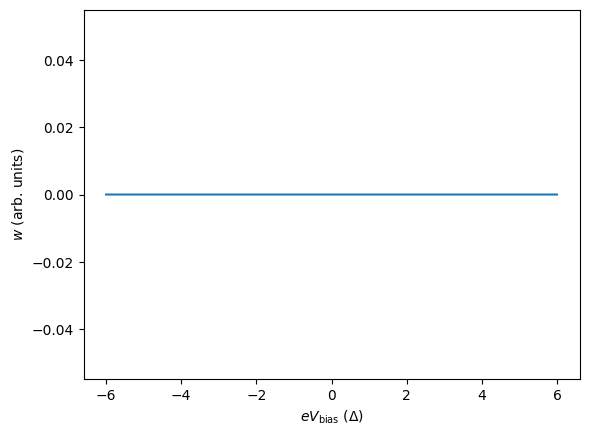

: 

In [ ]:


sigma = (1,2)
position = 2

def symmetric_weight(x: np.ndarray, 
                     position: int | float | list[int | float] | tuple[int | float, ...] | np.ndarray,
                     sigma: int | float | list[int | float] | tuple[int | float, ...] | np.ndarray, 
                     ):
    
    weight = np.full(x.shape[0], 0, dtype='float64')
    position = np.array(position, dtype='float64').ravel()
    sigma = np.array(sigma, dtype='float64').ravel()

    if len(position) == len(sigma):
        
    return weight

    # if type(sigma) is list and type(position) is list:
    #     if len(position) != len(sigma):
    #         raise Warning("Sigma should be either float, or list of same length as position.")
    #     for i, pos in enumerate(position):
    #         weight += np.exp(-0.5 * ((x - pos) / sigma[i])**2) + np.exp(-0.5 * ((x + pos) / sigma[i])**2)
    # elif type(sigma) is float or int and type(position) is list:
    #     for i, pos in enumerate(position):
    #         weight += np.exp(-0.5 * ((x - pos) / sigma)**2) + np.exp(-0.5 * ((x + pos) / sigma)**2)
    # else:
    #     raise Warning("Doesn't make sense..")
    # return weight

%matplotlib inline
plt.close(0)
plt.figure(0)
plt.plot(V_exp/V_gap, symmetric_weight(V_exp/Delta, position, sigma))
plt.xlabel(r"$eV_\mathrm{bias}$ ($\Delta$)")
plt.ylabel(r"$w$ (arb. units)")


In [279]:
position = (1., 1)
any([type(position) == int, type(position) == float, type(position) == list[int|float], type(position) == tuple[int|float, ...]])

False

In [ ]:
# Fit G_N first and set as constant parameter 

# Settings
num_generations = 30
sol_per_pop = 10

gene_space = [
    {"low": 188e-6, "high": 194e-6},   # Delta
    {"low": 1e-6,   "high": 20e-6},    # Gamma
    {"low": 0.30,   "high": 0.60},     # T
    {"low": 0.049,  "high": 0.052},    # G_N
]
%matplotlib inline
plt.close(0)
plt.figure(0)
plt.plot(V_exp/V_gap, symmetric_weight(V_exp/Delta))
plt.xlabel(r"$eV_\mathrm{bias}$ ($\Delta$)")
plt.ylabel(r"$w$ (arb. units)")


import pygad
import numpy as np
from tqdm import tqdm

pbar = tqdm(total=num_generations, desc="GA Progress")

# Callback-Funktion, die nach jeder Generation aufgerufen wird
def on_generation(ga_instance):
    pbar.update(1)

def fitness_func(ga, solution, solution_idx):
    Delta, Gamma, T, G_N = solution
    I_model = tunneling_current(V_exp, Delta, Gamma, T, G_N)

    # Mean squared error between model and data
    weight=symmetric_weight(V_exp/Delta)
    error = np.mean((I_model - I_exp)**2*weight)

    # Return negative error (GA maximizes the fitness)
    return -error

ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=int(sol_per_pop/3),
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop,
    num_genes=4,
    keep_parents=2,
    gene_space=gene_space,
    mutation_by_replacement=True,
    parent_selection_type="tournament",
    mutation_type="random",
    crossover_type="single_point",
    mutation_num_genes=1,
    on_generation=on_generation,
    )

ga_instance.run()
pbar.close()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Best solution parameters:", solution)

Delta, Gamma, T, G_N = solution
print("-------------------------------------------------------")
print(f"Δ={Delta*1e6:.3f} µeV, Γ={Gamma*1e6:05.1f} µeV, T={T*1e3:05.1f} mK, G_N={G_N:.3f}, u={-solution_fitness*1e21:08.4f}")
solution